In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [2]:
from sklearn.preprocessing import StandardScaler


def read_and_filter_dataset(datasets, devices,
                            use_features=None,
                            force_columns=None,
                            use_columns=None,
                            use_activities=None,
                            scale=True,
                            with_feature_selection=False):
    # read datasets
    df, df_labels = tflscripts.read_dataset(
            datasets,
            devices,
            with_feature_selection=with_feature_selection)
    df_labels = df_labels.loc[df_labels.index.isin(df.index)]
    df = df.loc[df.index.isin(df_labels.index)]

    # filter features
    if use_features is not None:
        df, __ = tflscripts.filter_by_features(df_source=df,
                                    use_features=use_features)
        if df is None:
            return None, None

    if force_columns is not None:
        use_columns = force_columns
        tflscripts.add_empty_columns_if_missing(df, force_columns)

    # filter specific columns
    if use_columns is not None:
        try:
            df = df[use_columns]
        except KeyError as ex:
            print('No such columns found')
            return None, None

#     null_df = df.loc[df_labels.label == configuration['activities'].index('Null')]
#     null_mean = null_df[null_df.columns].mean()
#     null_std = null_df[null_df.columns].std()

    # filter activities
    if use_activities is not None:
        df, df_labels = tflscripts.filter_by_activities(df, df_labels, use_activities)
        if df is None:
            print('Activities not found')
            return None, None
    # sort feature columns
    df = tflscripts.X_sort(df)

    # scale domains
    if scale:
        df[df.columns] = StandardScaler().fit_transform(df[df.columns])
#         df[df.columns] = (df[df.columns] - null_mean) / null_std
#         df = df.replace([np.inf, -np.inf], np.nan)
    return df, df_labels

In [3]:
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
#     "Knocking",
    "Phone vibrating"
]

configuration = tflscripts.read_configuration()
activities_i = [configuration['activities'].index(a) for a in activities]

use_features = "^(?!mag|light)"

In [6]:
source_dataset = 'synergy-final-iter1'
source_device = '128.237.254.195'
target_dataset = 'synergy-final-iter2'
target_device = '128.237.248.186'
use_features = '.*'

df_source, df_source_labels = read_and_filter_dataset(
        source_dataset + '-2s',
        source_device,
        use_features=use_features,
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_target, df_target_labels = read_and_filter_dataset(
        target_dataset + '-2s',
        target_device,
        use_features=use_features,
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

ppl = Pipeline([
    ('impute', Imputer()),
    ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
])

ppl.fit(df_source, df_source_labels['label'])

predicted = ppl.predict(df_target)
y_test = df_target_labels['label'].values

accuracy = accuracy_score(y_test, predicted)
print(accuracy)

results = []
for i in np.unique(y_test):
    activity = configuration['activities'][int(i)]
    correct = len([x for x in predicted[y_test == i] if x == i])
    incorrect = len([x for x in predicted[y_test == i] if x != i])
    results.append([activity, correct, incorrect])

0.489108910891


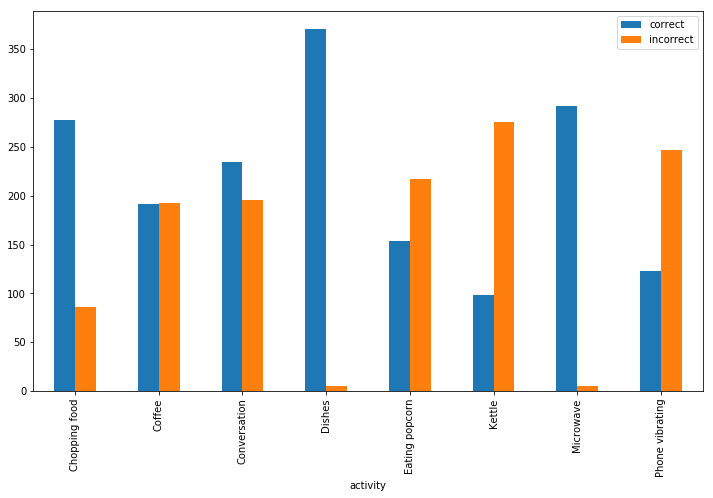

In [5]:
results_df = pd.DataFrame(results)
results_df.columns = ['activity', 'correct', 'incorrect']
results_df = results_df.sort_values('activity')
results_df = results_df.set_index('activity')

results_df.plot.bar()

0.944510503369


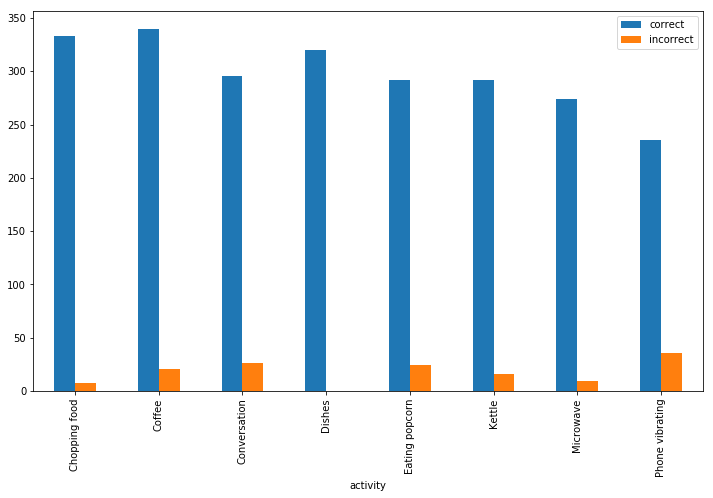

In [146]:
dataset = 'synergy-final-iter2'
device = '128.237.248.186'
dataset_2 = 'synergy-final-iter1'
device_2 = '128.237.254.195'
dataset_3 = 'synergy-final-iter3'
device_3 = '128.237.237.122'

df_1, df_1_labels = read_and_filter_dataset(
        dataset + '-2s',
        device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_2, df_2_labels = read_and_filter_dataset(
        dataset_2 + '-2s',
        device_2,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_3, df_3_labels = read_and_filter_dataset(
        dataset_3 + '-2s',
        device_3,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)


df = pd.concat([df_1, df_2, df_3])
df_labels = pd.concat([df_1_labels, df_2_labels, df_3_labels])

dfs = tflscripts.take_multiple_percentages_of_data(
        df, df_labels,
        [0.7, 0.3])

X_train, y_train = dfs[0]
X_test, y_test = dfs[1]

y_train = y_train['label']
y_test = y_test['label']

ppl = Pipeline([
    ('impute', Imputer()),
    ('clf', svm.LinearSVC())
])

ppl.fit(X_train, y_train)

predicted = ppl.predict(X_test)

accuracy = accuracy_score(y_test, predicted)
print(accuracy)

results = []
for i in np.unique(y_test):
    activity = configuration['activities'][int(i)]
    correct = len([x for x in predicted[y_test == i] if x == i])
    incorrect = len([x for x in predicted[y_test == i] if x != i])
    results.append([activity, correct, incorrect])

results_df = pd.DataFrame(results)
results_df.columns = ['activity', 'correct', 'incorrect']
results_df = results_df.sort_values('activity')
results_df = results_df.set_index('activity')

results_df.plot.bar()

0.289567068843


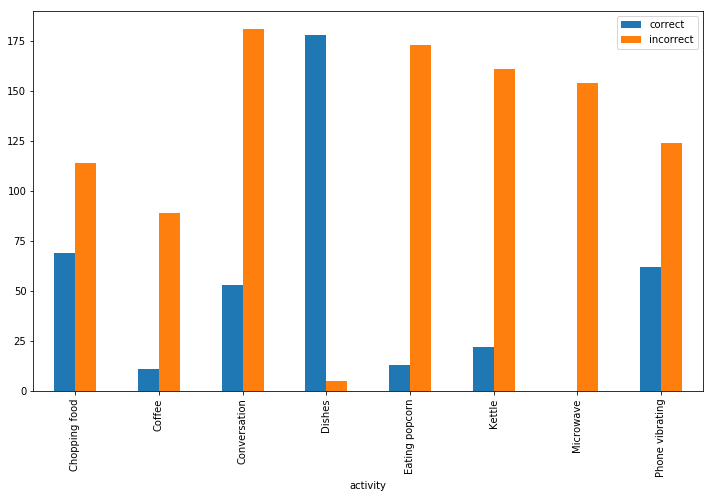

In [154]:
dataset_1 = 'synergy-final-iter2-2s'
device_1 = '128.237.248.186'
dataset_2 = 'synergy-final-iter1-2s'
device_2 = '128.237.254.195'
dataset_3 = 'synergy-final-iter3-2s'
device_3 = '128.237.237.122'
dataset_4 = 'scott-final-iter1-2s'
device_4 = '128.237.248.186'

df_1, df_1_labels = read_and_filter_dataset(
        dataset_1,
        device_1,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_2, df_2_labels = read_and_filter_dataset(
        dataset_2,
        device_2,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_3, df_3_labels = read_and_filter_dataset(
        dataset_3,
        device_3,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)



df = pd.concat([df_1, df_2, df_3])
df_labels = pd.concat([df_1_labels, df_2_labels, df_3_labels])

ppl = Pipeline([
    ('impute', Imputer()),
    ('clf', svm.LinearSVC())
])

ppl.fit(df, df_labels['label'])

df_target, df_target_labels = read_and_filter_dataset(
        dataset_4,
        device_4,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

predicted = ppl.predict(df_target)
y_test = df_target_labels['label']

accuracy = accuracy_score(y_test, predicted)
print(accuracy)

results = []
for i in np.unique(y_test):
    activity = configuration['activities'][int(i)]
    correct = len([x for x in predicted[y_test == i] if x == i])
    incorrect = len([x for x in predicted[y_test == i] if x != i])
    results.append([activity, correct, incorrect])

results_df = pd.DataFrame(results)
results_df.columns = ['activity', 'correct', 'incorrect']
results_df = results_df.sort_values('activity')
results_df = results_df.set_index('activity')

results_df.plot.bar()